# Bias correction of personal weather stations


This notebook presents how to use calculate Bias Correction Factors (BCF) for automated private weather stations (PWS) with the Python package `pypwsqc`. The package is based on the original R code available at https://github.com/LottedeVos/PWSQC/. In its original implementation, the functionality is embedded in the Station Outlier filter. In this notebook, the bias correction can be performed separately. It is recommended to apply the other QC filters first and only calculate BCF on filtered data. The BCF can also be calculated simultaneously as the Station Outlier filter. If you want to do that, use the Station Outlier filter notebook and set the variable `bias_corr` to _True_.

[Publication: de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. Geophysical Research Letters, 46(15), 8820-8829](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731)

`pypwsqc` depends on the `poligrain`, `xarray`, `pandas` and `numpy` packages. Make sure to install and import the required packages first.

In [1]:
import poligrain as plg
import xarray as xr
# import pypwsqc

In [2]:
import pandas as pd


In [ ]:
import flagging

## Download example data

In this example, we use an open PWS dataset from Amsterdam, called the "AMS PWS" dataset. By running the cell below, an example NetCDF-file will be downloaded to your current repository (if your machine is connected to the internet).

In [ ]:
!curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc

## Data preparations

This package handles rainfall data as `xarray`  Datasets. The data set must have `time` and `id` dimensions, `latitude` and `longitude` as coordinates, and `rainfall` as data variable.

An example of how to convert .csv data to a `xarray` dataset is found [here](https://github.com/OpenSenseAction/OS_data_format_conventions/blob/main/notebooks/PWS_example_dataset.ipynb).

We now load the data set under the name  `ds_pws`.

In [42]:
ds_pws = xr.open_dataset("OpenSense_PWS_example_format_data_with_variables.nc")
ds_pws

<xarray.Dataset> Size: 589MB
Dimensions:       (time: 219168, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id            (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
    elevation     (id) <U3 2kB ...
    latitude      (id) float64 1kB ...
    longitude     (id) float64 1kB ...
    x             (id) float64 1kB ...
    y             (id) float64 1kB ...
Data variables:
    rainfall      (id, time) float64 235MB ...
    nbrs_not_nan  (id, time) int32 117MB ...
    reference     (id, time) float64 235MB ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

### Reproject coordinates 

First we reproject the coordinates to a local metric coordinate reference system to allow for distance calculations. In the Amsterdam example we use EPSG:25832. **Remember to use a local metric reference system for your use case!** We use the function `spatial.project_point_coordinates` in the `poligrain`package. 

In [ ]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

In [43]:
ds_pws = ds_pws.sel(time = slice('2017-10-01 00:00:00','2018-01-01 00:00:00'))
ds_pws

<xarray.Dataset> Size: 71MB
Dimensions:       (time: 26497, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 212kB 2017-10-01 ... 2018-01-01
  * id            (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
    elevation     (id) <U3 2kB ...
    latitude      (id) float64 1kB ...
    longitude     (id) float64 1kB ...
    x             (id) float64 1kB ...
    y             (id) float64 1kB ...
Data variables:
    rainfall      (id, time) float64 28MB ...
    nbrs_not_nan  (id, time) int32 14MB ...
    reference     (id, time) float64 28MB ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

### Create distance matrix

Then, we calculate the distances between all stations in our data set. If your data set has a large number of stations this can take some time.

In [4]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

### Select range for neighbouring checks

The quality control is performed by comparing time series of each station with the time series of neighbouring stations within a specificed range `max_distance`. The selected range depends on the use case and area of interest. In this example, we use 10'000 meters. `max_distance` is called `d` in the [original publication](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731).

### Select considered range around each station

In [5]:
max_distance = 10e3

## Bias correction

Now the data set is prepared to calculate bias correction factors. 

A bias correction factor will be calculated per time step over a rolling window of length `evaluation_period` time steps. Define the window length by defining the variable `evaluation_period` in the cell below. The default is to use the median rainfall of the neighboring stations as reference. To use another data source as reference, that data must be added as a variable named `reference` to the xarray data set. [Here](https://github.com/OpenSenseAction/OS_data_format_conventions/blob/main/notebooks/PWS_example_dataset.ipynb) you can find an example of how to construct an xarray data set. `beta` is a bias correction parameter (default 0.2). `dbc` is the default bias correction factor (default 1). 

In [8]:
evaluation_period = 8064
beta = 0.2
dbc = 1

In [66]:
def bias_correction(
    ds_pws,
    evaluation_period,
    distance_matrix,
    max_distance,
    beta = 0.2,
    dbc = 1,
):
    """Bias Correction Factor (BCF) Calculation.

    This function applies the BCF calculation from the R package PWSQC.

    The Python code has been translated from the original R code,
    to be found here: https://github.com/LottedeVos/PWSQC/tree/master/R.

    In its original implementation, the functionality is embedded in the
    Station Outlier filter. Here, the bias correction can be performed
    separately. It is recommended to apply the other QC filters first 
    and only calculate BCF on filtered data.

    The default is to use the median rainfall of the neighboring stations
    as reference. To use another data source as reference, that data must
    be added as a variable named `reference` to the xarray data set.

    The function returns an array BCF values per station and time step.
    
    Parameters
    ----------
    ds_pws
        xarray data set
    nbrs_not_nan
        Number of neighbouring stations reporting rainfall
    evaluation_period
        length of (rolling) window for correlation calculation
        [timesteps]
    distance_matrix
        matrix with distances between all stations in the data set
    max_distance
        considered range around each station [m]
    bias_corr (optional)
        boolean to decide if bias correction factor will be calculated. Default False
    beta
        bias correction parameter. Default 0.2
    dbc
        default bias correction factor. Default 1

    Returns
    -------
    npt.NDArray
        Time series of flags.
    """
    # calculate support variables
    if "reference" not in ds_pws:
        nbrs_not_nan = []
        reference = []
        for pws_id in ds_pws.id.data:
            neighbor_ids = distance_matrix.id.data[
                (distance_matrix.sel(id=pws_id) < max_distance)
                & (distance_matrix.sel(id=pws_id) > 0)
            ]

            N = (
                ds_pws.rainfall.sel(id=neighbor_ids).notnull().sum(dim="id")
            )  # noqa: PD004
            nbrs_not_nan.append(N)

            median = ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id")
            reference.append(median)

        ds_pws["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim="id")
        ds_pws["reference"] = xr.concat(reference, dim="id")

    # For each station (ID), get the index of the first non-NaN rainfall value
    first_non_nan_index = ds_pws["rainfall"].notnull().argmax(dim="time")  # noqa: PD004

    for i in range(len(ds_pws.id)):
        BCF_prev = dbc
        ds_station = ds_pws.isel(id=i)
        pws_id = ds_station.id.to_numpy()

        # picking stations within max_distnance, excluding itself,
        # for the whole duration of the time series
        neighbor_ids = distance_matrix.id.data[
            (distance_matrix.sel(id=pws_id) < max_distance)
            & (distance_matrix.sel(id=pws_id) > 0)
        ]
        
        # create data set for neighbors
        ds_neighbors = ds_pws.sel(id=neighbor_ids)

        # initialize with default bias correction factor
        ds_pws["bias_corr_factor"] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time))) * dbc, dims=("id", "time"))
        ds_pws["BCF_new"] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time))) * -999, dims=("id", "time"))
            
        # Set so_flag to -1 up to first valid index
        first_valid_time = first_non_nan_index[i].item()
        ds_pws.bias_corr_factor[i, :first_valid_time] = -1
        
        # disregard warm up period
        ds_pws.bias_corr_factor[i, first_valid_time : (first_valid_time + evaluation_period)] = (
            -1
        )
        s_rainfall = ds_station.rainfall.to_series()
        s_reference = ds_station.reference.to_series()
        diff = s_rainfall - s_reference
        mean_diff = diff.rolling(evaluation_period, min_periods = 1, center = False).mean() # TODO: nanmean
        mean_ref = s_reference.rolling(evaluation_period, min_periods = 1, center = False).mean() # TODO: nanmean
        bias = mean_diff/mean_ref
        BCF_new = 1/(1+bias)
        ds_pws["BCF_new"][i]= xr.DataArray.from_series(BCF_new)

        BCF_shifted = ds_pws['BCF_new'][i].shift(time=-1)
        
        condition3 = (np.abs(np.log(ds_pws.BCF_new[i] / BCF_prev)) > np.log(1 + beta)) & (ds_pws.bias_corr_factor[i] == 1)
        ds_pws.bias_corr_factor[i] = xr.where(condition3, ds_pws.BCF_new[i], BCF_shifted) # ds_pws.bias_corr_factor[i]
        
        # return ds_pws # TODO: of previous time step

In [67]:
test = bias_correction(
    ds_pws,
    evaluation_period,
    distance_matrix,
    max_distance,
    beta = 0.2,
    dbc = 1,
)

C:\Users\a002461\AppData\Local\miniforge3\envs\OS_env\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\a002461\AppData\Local\miniforge3\envs\OS_env\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\a002461\AppData\Local\miniforge3\envs\OS_env\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\a002461\AppData\Local\miniforge3\envs\OS_env\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\a002461\AppData\Local\miniforge3\envs\OS_env\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\a002461\AppData\Local\miniforge3\envs\OS_env\Lib\si

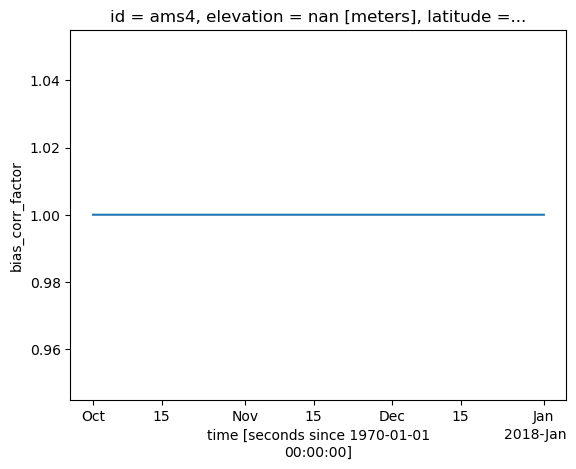

In [76]:
ds_pws.bias_corr_factor.sel(id = "ams4").plot()

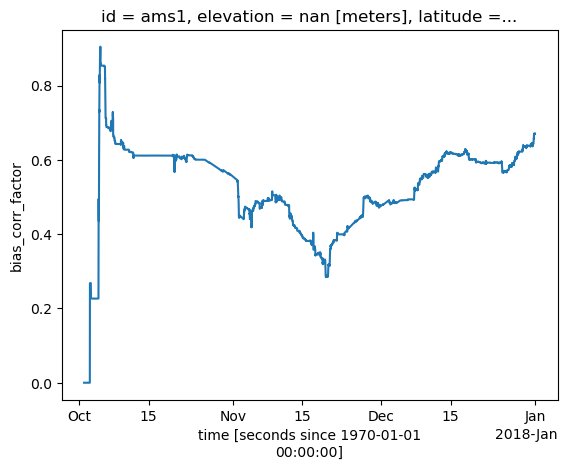

In [47]:
test.bias_corr_factor.isel(id = 0).plot()

In [10]:
import numpy as np

### Save filtered data

In [ ]:
ds_pws_filtered.to_netcdf("so_filtered_dataset.nc")